In [1]:
import argparse
import os
import random
import torch as t
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision as tv
# import torchvision.datasets as dset
# import torchvision.transforms as transforms
# import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
manualSeed = 42
print("Random seed = ", manualSeed)
random.seed(manualSeed)
t.manual_seed(manualSeed)

Random seed =  42


In [251]:
dataroot = './data/celeba'
num_workers = 2
batch_size=64
image_size=64

n_labels = 100 #no. total labels in the target dataste
nc = 1 #no. channels of images
nz = 100
ngf = 64 #no. generator's feature maps
ndf = 64 #no. discriminator's feature maps
num_epochs = 5
lr = .0002
beta1 = .5
ngpu = 1 #no. gpu


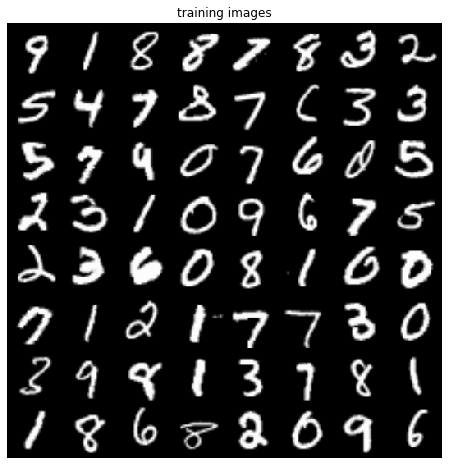

In [258]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
transforms=tv.transforms.Compose([
                               tv.transforms.Resize(image_size),
                               tv.transforms.CenterCrop(image_size),
                               tv.transforms.ToTensor(),
                               tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),    
                                ])

transforms=tv.transforms.Compose([
                               tv.transforms.Resize(image_size),
                               tv.transforms.CenterCrop(image_size),
                               tv.transforms.ToTensor(),
                               tv.transforms.Normalize((.5,), (.5,)),    
                                ])



# dataset = tv.datasets.ImageFolder(root=dataroot,
#                                  transform=transforms
#                                  ]))
# dataset = tv.datasets.ImageFolder(root=dataroot,

#                            ]))

#dataset = tv.datasets.CIFAR10('./data', train=True, download=True, transform=transforms)
dataset = tv.datasets.MNIST('./data', train=True, download=True, transform=transforms)
#dataset = tv.datasets.CIFAR100('./data', train=True, download=True, transform=transforms)

dataloader = t.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

device = t.device("cuda:0" if (t.cuda.is_available() and ngpu > 0) else 'cpu')

real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('training images')
plt.imshow(np.transpose(tv.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [259]:
#now, init model weight according to normal distribution, why?
def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        t.nn.init.normal_(m.weight.data, .0, .02)
    elif classname.find('BatchNorm')!= -1:
        t.nn.init.normal_(m.weight.data, 1.0, .02)
        t.nn.init.constant_(m.bias.data, 0.0)

In [260]:
class Generator(t.nn.Module):
    def __init__(self, ngpu, n_labels, image_info):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.n_labels = n_labels
        nc, h, w = image_info
        self.h = h  #input size
        self.w = w  #input size
        self.nc = nc        
        
        self.conv1a = t.nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False)
        self.bn1a = t.nn.BatchNorm2d(ngf * 8)
        
        self.conv1b = t.nn.ConvTranspose2d( n_labels, ngf * 2, 4, 1, 0, bias=False)
        self.bn1b = t.nn.BatchNorm2d(ngf * 2)
        
        self.conv2 = t.nn.ConvTranspose2d( ngf * 10, ngf * 4, 4, 2, 1, bias=False)
        self.bn2 = t.nn.BatchNorm2d(ngf * 4)
        self.conv3 = t.nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.bn3 = t.nn.BatchNorm2d(ngf * 2)
        self.conv4 = t.nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False)
        self.bn4 = t.nn.BatchNorm2d(ngf * 1)
        self.conv5 = t.nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False)
        

    def forward(self, x, labels):
        x1 = t.nn.functional.leaky_relu(self.bn1a(self.conv1a(x)), negative_slope=0.2)
        
        x2 = t.nn.functional.one_hot(labels.type(t.LongTensor), self.n_labels).type(t.FloatTensor)
        x2 = x2.unsqueeze(2).unsqueeze(3).to(device)
        x2 = t.nn.functional.leaky_relu(self.bn1b(self.conv1b(x2)), negative_slope=0.2)
        try:
            x = t.cat((x1, x2), dim=1)
        except:
            print (x.shape, labels.shape, x1.shape, x2.shape)
        
        x = t.nn.functional.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = t.nn.functional.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = t.nn.functional.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        x = t.tanh(self.conv5(x))
        return x

class GeneratorV1(t.nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.conv1 = t.nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False)
        self.bn1 = t.nn.BatchNorm2d(ngf * 8)
        self.conv2 = t.nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.bn2 = t.nn.BatchNorm2d(ngf * 4)
        self.conv3 = t.nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.bn3 = t.nn.BatchNorm2d(ngf * 2)
        self.conv4 = t.nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False)
        self.bn4 = t.nn.BatchNorm2d(ngf * 1)
        self.conv5 = t.nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False)
        

    def forward(self, x):
        x = t.nn.functional.relu(self.bn1(self.conv1(x)))
        x = t.nn.functional.relu(self.bn2(self.conv2(x)))
        x = t.nn.functional.relu(self.bn3(self.conv3(x)))
        x = t.nn.functional.relu(self.bn4(self.conv4(x)))
        x = t.tanh(self.conv5(x))
        return x

class GeneratorV0(t.nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = t.nn.Sequential(
            # input is Z, going into a convolution
            t.nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            t.nn.BatchNorm2d(ngf * 8),
            t.nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            t.nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ngf * 4),
            t.nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            t.nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ngf * 2),
            t.nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            t.nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ngf),
            t.nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            t.nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            t.nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [261]:
netg = Generator(ngpu, n_labels, (nc, image_size, image_size)).to(device)
if (device.type=='cuda') and (ngpu > 1):
    netg = t.nn.DataParallel(netg, list(range(ngpu)))
netg.apply(weight_init)  #apply weight_init recursively to all children
print(netg)

Generator(
  (conv1a): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1a): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1b): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1b): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(640, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), 

In [262]:
for item in netg.children():
    for item2 in item.children():
        print (item2.__class__.__name__)


In [263]:
class Discriminator(t.nn.Module):
    def __init__(self, ngpu, n_labels, image_info):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.n_labels = n_labels
        nc, h, w = image_info
        self.h = h  #input size
        self.w = w  #input size
        self.nc = nc
        
        self.n_cond = 32 #use 32 neuron to encode conditions in the first layers
        
        self.conv1a = t.nn.Conv2d(self.nc, ndf-self.n_cond, 4, 2, 1, bias=False)
        self.bn1a = t.nn.BatchNorm2d((ndf-self.n_cond) * 1)
        self.conv1b = t.nn.Conv2d(nc, self.n_cond, 4, 2, 1, bias=False)
        self.bn1b = t.nn.BatchNorm2d(self.n_cond * 1)
        self.fc1 = t.nn.Linear(n_labels, self.nc * self.h * self.w)
        
        self.conv2 = t.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.bn2 = t.nn.BatchNorm2d(ndf * 2)
        self.conv3 = t.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.bn3 = t.nn.BatchNorm2d(ndf * 4)
        self.conv4 = t.nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.bn4 = t.nn.BatchNorm2d(ndf * 8)
        self.conv5 = t.nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)

    def forward(self, x, labels):
        x1 = t.nn.functional.leaky_relu(self.bn1a(self.conv1a(x)), negative_slope=0.2)
        
        #_, fm, h, w = x1.shape
        x2 = t.nn.functional.one_hot(labels.type(t.LongTensor), self.n_labels).type(t.FloatTensor).to(device)
        x2 = self.fc1(x2).view(-1, self.nc, self.h, self.w)
        x2 = t.nn.functional.leaky_relu(self.bn1b(self.conv1b(x2)), negative_slope=0.2)
        x = t.cat((x1, x2), dim=1)
        
        x = t.nn.functional.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = t.nn.functional.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = t.nn.functional.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        x = t.sigmoid(self.conv5(x))
        return x


    
#####DON"T USE
class DiscriminatorV1(t.nn.Module):
    def __init__(self, ngpu, n_labels, image_info):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.conv1 = t.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.bn1 = t.nn.BatchNorm2d(ndf * 1)

        self.conv2 = t.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.bn2 = t.nn.BatchNorm2d(ndf * 2)
        self.conv3 = t.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.bn3 = t.nn.BatchNorm2d(ndf * 4)
        self.conv4 = t.nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.bn4 = t.nn.BatchNorm2d(ndf * 8)
        self.conv5 = t.nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)

    def forward(self, x, labels):

        x = t.nn.functional.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.2)
        x = t.nn.functional.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = t.nn.functional.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = t.nn.functional.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        x = t.sigmoid(self.conv5(x))
        return x


class DiscriminatorV0(t.nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = t.nn.Sequential(
            # input is (nc) x 64 x 64
            t.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            t.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            t.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ndf * 2),
            t.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            t.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ndf * 4),
            t.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            t.nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ndf * 8),
            t.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            t.nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            t.nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [264]:
netd = Discriminator(ngpu, n_labels, (nc, image_size, image_size)).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netd = t.nn.DataParallel(netd, list(range(ngpu)))
netd.apply(weight_init)
print(netd)

Discriminator(
  (conv1a): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1a): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1b): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=100, out_features=4096, bias=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512,

In [265]:
criterion = t.nn.BCELoss()
#criterion = t.nn.BCEWithLogitsLoss()

fixed_noise = t.randn(64, nz, 1, 1, device=device)
fixed_labels = t.randint(0, 10, (64,), device=device)

label_real = 1
label_fake = 0

optimizer_d = optim.Adam(netd.parameters(), lr=lr, betas=(beta1, .999))
optimizer_g = optim.Adam(netg.parameters(), lr=lr, betas=(beta1, .999))


In [ ]:
def add_condition(nz, c, n, b_size):
    #TODO: add the class as the precondition for the data into the 
    #INPUT: array of class ground truth c, size of noise nz, number of ground truth classes
            #a noise vector of size (batch, )
    c_onehot =  t.nn.functional.one_hot(c.to(t.int64).clone().detach().to(device), 10).type(t.FloatTensor)
    noise = t.randn(b_size, nz, device=device)
    result = t.cat((noise.squeeze().to(device), c_onehot.to(device)), 1) #ignore batch at dim=0
    return result.unsqueeze(2).unsqueeze(3)

img_list = []
g_loss = []
d_loss = []
iters = 0

print ('Start training')

for epoch in range(num_epochs):
    for i, (img, img_labels) in enumerate(dataloader):
        netd.zero_grad()
        
        #train d
        #train d with all read data batch
        real_cpu = img.to(device)
        b_size = real_cpu.size(0)
        label = t.full((b_size,), label_real, dtype=t.float, device=device) #create a vector [label_real, ...] equal to batch size
        output = netd(real_cpu, img_labels).view(-1)
        err_d_real = criterion(output, label)
        err_d_real.backward()
        D_x = output.mean().item() #why mean here? mean over all batch values?
        #train d with fake data from g
        #noise = add_condition(nz, label, 10, b_size)
        noise = t.randn(b_size, nz, 1, 1, device=device)
        fake = netg(noise, img_labels)
        label.fill_(label_fake) #change the gt label, no be [label_fake, ...] instead
        output = netd(fake.detach(), img_labels).view(-1)
        err_d_fake = criterion(output, label)
        err_d_fake.backward()
        D_G_z1 = output.mean().item() #D(G(z)) over batch of z
        err_d = err_d_real + err_d_fake
        
        optimizer_d.step()
        
        #train g: minimize 1 - D(G(z)) is maximize (D(G(z)))
        netg.zero_grad()
        label.fill_(label_real)
        output=netd(fake, img_labels).view(-1)
        err_g = criterion(output, label)
        err_g.backward()
        D_G_z2 = output.mean().item()
        
        optimizer_g.step()
        
        if i%50 == 0:
            print (f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] \t Loss_D: {err_d.item():.4f}, Loss_G: {err_g.item():.4f} \t D(x): {D_x} \t D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
        
        g_loss.append(err_g.item())
        d_loss.append(err_d.item())
        
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with t.no_grad():
                fake = netg(fixed_noise, fixed_labels).detach().cpu()
            img_list.append(tv.utils.make_grid(fake, padding=2, normalize=True))    
            
        iters += 1#fine grain iteration 

Start training
[0/5][0/938] 	 Loss_D: 1.5032, Loss_G: 4.8237 	 D(x): 0.5659197568893433 	 D(G(z)): 0.4972 / 0.0113
[0/5][50/938] 	 Loss_D: 0.0788, Loss_G: 7.9751 	 D(x): 0.9365999102592468 	 D(G(z)): 0.0003 / 0.0005
[0/5][100/938] 	 Loss_D: 0.8359, Loss_G: 2.8140 	 D(x): 0.6094130277633667 	 D(G(z)): 0.0147 / 0.0968
[0/5][150/938] 	 Loss_D: 0.8873, Loss_G: 1.4462 	 D(x): 0.5446200966835022 	 D(G(z)): 0.0585 / 0.3033
[0/5][200/938] 	 Loss_D: 0.6331, Loss_G: 1.1984 	 D(x): 0.6325856447219849 	 D(G(z)): 0.0340 / 0.3761
[0/5][250/938] 	 Loss_D: 0.5456, Loss_G: 3.8376 	 D(x): 0.9375177025794983 	 D(G(z)): 0.3318 / 0.0293
[0/5][300/938] 	 Loss_D: 0.7596, Loss_G: 0.9402 	 D(x): 0.578454852104187 	 D(G(z)): 0.0129 / 0.4502
[0/5][350/938] 	 Loss_D: 0.2720, Loss_G: 2.5739 	 D(x): 0.8466045260429382 	 D(G(z)): 0.0765 / 0.0947
[0/5][400/938] 	 Loss_D: 0.4282, Loss_G: 3.9738 	 D(x): 0.8385006189346313 	 D(G(z)): 0.1501 / 0.0413
[0/5][450/938] 	 Loss_D: 0.2901, Loss_G: 3.0050 	 D(x): 0.8848909139633

In [267]:
img.shape, img_labels.shape

(torch.Size([32, 1, 64, 64]), torch.Size([32]))

In [268]:
real_cpu.shape, netd(real_cpu, img_labels).view(-1).shape

(torch.Size([32, 1, 64, 64]), torch.Size([32]))

In [269]:
fake.shape

torch.Size([64, 1, 64, 64])

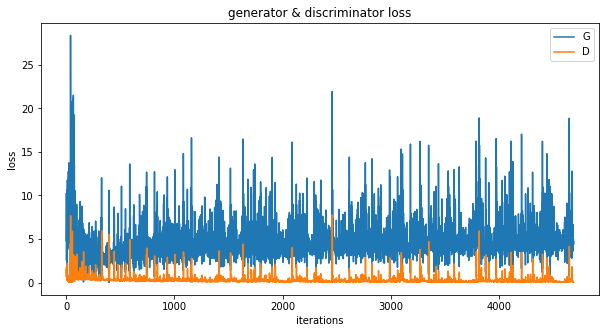

In [270]:
plt.figure(figsize=(10, 5))
plt.title('generator & discriminator loss')
plt.plot(g_loss, label='G')
plt.plot(d_loss, label='D')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()


In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

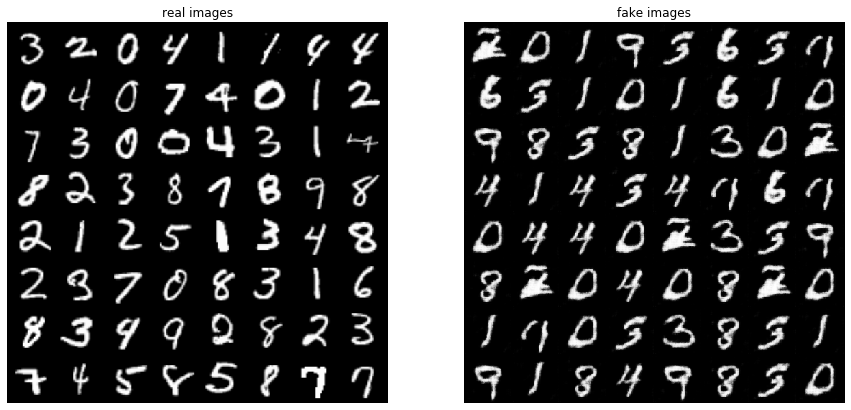

In [272]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('real images')
plt.imshow(np.transpose(tv.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('fake images')
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))


In [119]:
noise.shape

torch.Size([64, 120, 1, 1])